# Policy Gradient on Racetrack Environment (Optimized)

This notebook implements a Policy Gradient method for a custom racetrack environment using PyTorch. It includes:
- Dynamic input size handling
- Entropy-based regularization
- Advantage normalization
- Gradient clipping
- **Performance optimization** by disabling rendering

We use the REINFORCE algorithm, which is a Monte Carlo policy gradient method for optimizing the policy network.

## 1. Imports and Environment Setup
We define all necessary packages and configure the racetrack environment. We use an `OccupancyGrid` observation with continuous lateral actions.

In [37]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fast mode for training
training = True
render_mode = None if training else "human"

config = {
    "observation": {
        "type": "OccupancyGrid",
        "features": ['presence', 'on_road'],
        "grid_size": [[-18, 18], [-18, 18]],
        "grid_step": [3, 3],
        "as_image": False,
        "align_to_vehicle_axes": True
    },
    "action": {
        "type": "ContinuousAction",
        "longitudinal": False,
        "lateral": True
    },
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "duration": 100,
    "collision_reward": -1,
    "lane_centering_cost": 4,
    "action_reward": -0.3,
    "controlled_vehicles": 1,
    "other_vehicles": 0,
    "screen_width": 600,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": False,
    "render_agent": False if training else True,
    "offscreen_rendering": True if training else False
}

env = gym.make("racetrack-v0", render_mode=render_mode)
env.unwrapped.configure(config)
obs_sample, _ = env.reset()

obs_shape = obs_sample.shape
act_dim = env.action_space.shape[0] if len(env.action_space.shape) > 0 else 1


## 2. Actor and Critic Networks
We define two neural networks:
- The **Actor** outputs the mean of a Gaussian distribution over actions.
- The **Critic** predicts the state value to estimate advantage.

In [38]:
class Actor(nn.Module):
    def __init__(self, obs_shape, act_dim, hidden_size=64):
        super().__init__()
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, *obs_shape)
            n_flatten = self.flatten(dummy).shape[1]
        self.net = nn.Sequential(
            nn.Linear(n_flatten, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.mean = nn.Linear(hidden_size, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        x = self.flatten(obs)
        x = self.net(x)
        mu = self.mean(x)
        std = self.log_std.exp().expand_as(mu)
        return Normal(mu, std)

class Critic(nn.Module):
    def __init__(self, obs_shape, hidden_size=64):
        super().__init__()
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, *obs_shape)
            n_flatten = self.flatten(dummy).shape[1]
        self.v = nn.Sequential(
            nn.Linear(n_flatten, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, obs):
        x = self.flatten(obs)
        return self.v(x).squeeze(-1)

# Model initialization
actor = Actor(obs_shape, act_dim).to(device)
critic = Critic(obs_shape).to(device)
opt_actor = optim.AdamW(actor.parameters(), lr=1e-3)
opt_critic = optim.AdamW(critic.parameters(), lr=1e-3)


## 3. Training Loop — REINFORCE with Baseline
We collect one trajectory per epoch, compute returns and advantages, and update both actor and critic.

# Rendering the trained agent

In [39]:
import torch

gamma = 0.99
epochs = 200

# --- buffers de métrica ---
return_hist      = []   # retorno total por episódio
policy_loss_hist = []   # perda da política
value_loss_hist  = []   # perda do crítico
entropy_hist     = []   # entropia média da política
ep_len_hist      = []   # nº de passos no episódio

for epoch in range(epochs):
    obs, _ = env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    log_probs, values, rewards = [], [], []

    done = False
    step = 0
    while not done and step < 100:
        dist = actor(obs)
        value = critic(obs)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1)

        obs_next, reward, done, truncated, _ = env.step(action.cpu().numpy()[0])
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)

        obs = torch.tensor(obs_next, dtype=torch.float32, device=device).unsqueeze(0)
        step += 1

    returns, G = [], 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    values = torch.cat(values)
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    log_probs = torch.cat(log_probs)
    policy_loss = -(log_probs * advantages.detach()).mean()
    value_loss = advantages.pow(2).mean()
    entropy = dist.entropy().mean()
    loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

    # ---------------- atualização dos pesos (já existente) ----------------
    opt_actor.zero_grad()
    opt_critic.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
    opt_actor.step()
    opt_critic.step()

    # ------------------- grava as métricas -------------------
    ep_return = sum(rewards)
    return_hist.append(ep_return)

    policy_loss_hist.append(policy_loss.item())
    value_loss_hist.append(value_loss.item())
    entropy_hist.append(entropy.item())
    ep_len_hist.append(step)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Return: {returns.sum().item():.1f}")

# Save the model after training
torch.save(actor.state_dict(), 'actor_model.pth')
torch.save(critic.state_dict(), 'critic_model.pth')

print("Model saved successfully.")


Epoch 0 | Return: 473.5
Epoch 10 | Return: 605.6
Epoch 20 | Return: 16.6
Epoch 30 | Return: 71.0
Epoch 40 | Return: 300.1
Epoch 50 | Return: 100.0
Epoch 60 | Return: 1070.2
Epoch 70 | Return: 377.9
Epoch 80 | Return: 477.8
Epoch 90 | Return: 519.0
Epoch 100 | Return: 1391.3
Epoch 110 | Return: 1157.1
Epoch 120 | Return: 1548.5
Epoch 130 | Return: 871.5
Epoch 140 | Return: 1436.4
Epoch 150 | Return: 571.3
Epoch 160 | Return: 1639.5
Epoch 170 | Return: 1524.9
Epoch 180 | Return: 1889.5
Epoch 190 | Return: 1619.5
Model saved successfully.


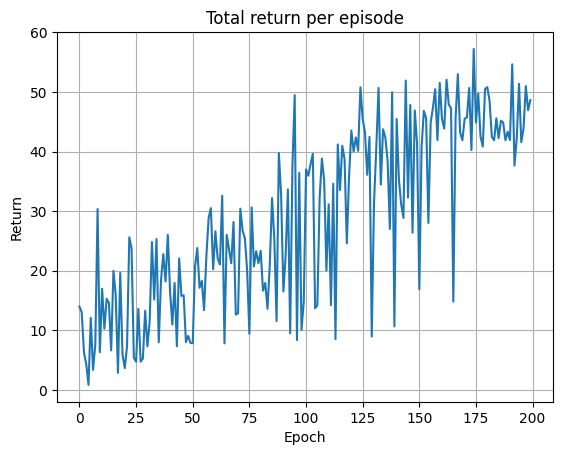

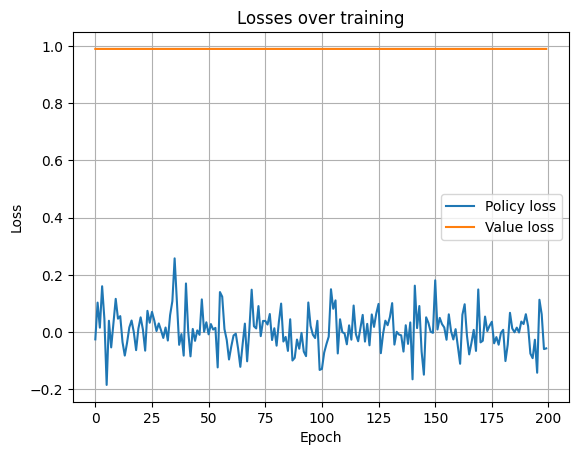

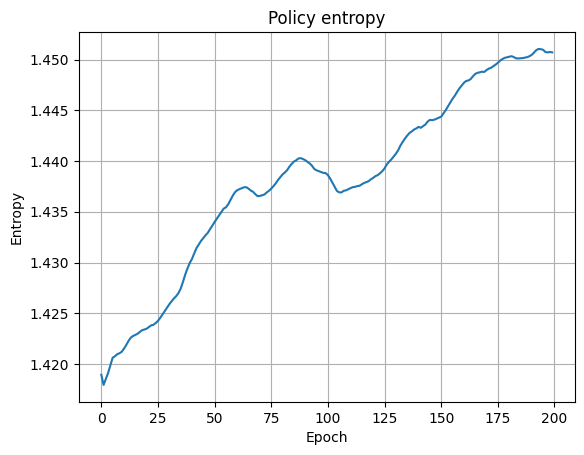

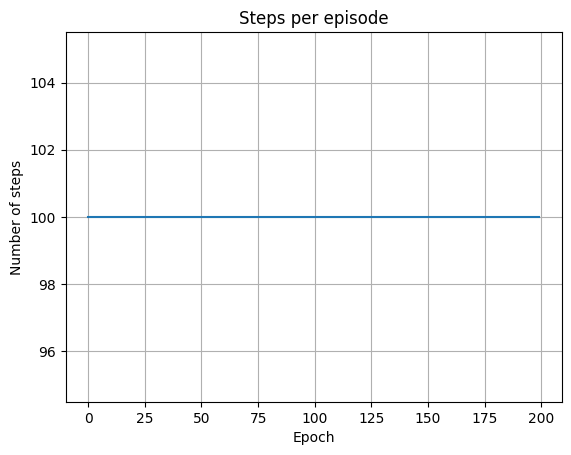

In [40]:
import matplotlib.pyplot as plt

# ---------- Return ----------
plt.figure()
plt.plot(return_hist)
plt.title("Total return per episode")
plt.xlabel("Epoch")
plt.ylabel("Return")
plt.grid(True)
plt.show()

# ---------- 2. Losses ----------
plt.figure()
plt.plot(policy_loss_hist, label='Policy loss')
plt.plot(value_loss_hist,  label='Value loss')
plt.title("Losses over training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 3. Entropy ----------
plt.figure()
plt.plot(entropy_hist)
plt.title("Policy entropy")
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

# ---------- 4. Episode duration ----------
plt.figure()
plt.plot(ep_len_hist)
plt.title("Steps per episode")
plt.xlabel("Epoch")
plt.ylabel("Number of steps")
plt.grid(True)
plt.show()


In [42]:
env_render = gym.make("racetrack-v0", render_mode="human")
env_render.unwrapped.configure(config)

obs, _ = env_render.reset()
obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
done = False
step = 0

while not done and step < 300:
    dist = actor(obs)
    action = dist.mean  
    obs_next, reward, done, truncated, _ = env_render.step(action.detach().cpu().numpy()[0])
    obs = torch.tensor(obs_next, dtype=torch.float32, device=device).unsqueeze(0)
    step += 1

env_render.close()
